# ОИАД. Лабораторная работа №4

Используйте набор данных **datasets/famcs_students.csv**

binary_cols = [ss, interest, weekend_study, bad_sleep, glasses, anime, study_form, literature]

Исползуйте целевую переменную $y=$ binary_cols[N % 8], где $N$ - номер в списке группы. Остальные переменные используйте в качестве признаков $X$ (предикторов). Вы можете отобрать наиболее информативные (по вашему экспертному мнению) признаки, но не менее 5.

Необходимо построить несколько моделей бинарной классификации $y$ по признакам $X$.

In [20]:
import numpy as np
import pandas as pd
import typing as tp
from statistics import mode
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

In [21]:
df = pd.read_csv("../datasets/famcs_students.csv")
print(df.shape)
df.head()

(127, 25)


,cource,group,stream,sex,age,ss,interest,os,weekend_study,bad_sleep,...,social,sport,miss,study_form,foot_size,eye_color,score,retake,hostel,literature
0,4,11,Прикладная информатика,М,20.0,Нет,Математика,MacOS,Да,Да,...,Экстраверт,"Редко, легкая физкультура",3.0,Бюджет,48.0,Карие,9.2,0,"Нет, я из Минска",Да
1,4,11,Прикладная информатика,Ж,20.0,Нет,Программирование,MacOS,Нет,Нет,...,Экстраверт,"Да, я спортсмен",5.0,Бюджет,39.0,Зеленые,8.8,0,"Нет, я из Минска",Да
2,4,11,Прикладная информатика,Ж,19.0,Нет,Программирование,MacOS,Да,Нет,...,Экстраверт,Вообще нет,10.0,Бюджет,41.0,Карие,8.8,0,"Нет, я из Минска",Да
3,4,11,Прикладная информатика,Ж,20.0,Нет,Математика,MacOS,Да,Да,...,Экстраверт,"Да, я спортсмен",3.0,Бюджет,36.0,Карие,8.8,0,"Нет, я из Минска",Да
4,4,11,Прикладная информатика,М,20.0,Нет,Математика,Windows,Да,Нет,...,Интроверт,Вообще нет,1.0,Бюджет,46.0,Зеленые,9.0,0,"Нет, я из Минска",Да


In [22]:
binary_cols = ["ss", "interest", "weekend_study", "bad_sleep", "glasses", "anime", "study_form", "literature"]
N = 26
target_column = binary_cols[N % 8]
target_column

'weekend_study'

In [23]:
df[target_column].isna().sum()

np.int64(0)

In [24]:
my_df = df.loc[:, binary_cols]
my_df.head()

,ss,interest,weekend_study,bad_sleep,glasses,anime,study_form,literature
0,Нет,Математика,Да,Да,Нет,Нет,Бюджет,Да
1,Нет,Программирование,Нет,Нет,Нет,Нет,Бюджет,Да
2,Нет,Программирование,Да,Нет,Нет,Нет,Бюджет,Да
3,Нет,Математика,Да,Да,Нет,Нет,Бюджет,Да
4,Нет,Математика,Да,Нет,Нет,Нет,Бюджет,Да


In [25]:
ohe_df = pd.get_dummies(my_df.loc[:, my_df.columns], drop_first=True).astype(int)
ohe_df = ohe_df.rename(columns={"weekend_study_Нет": "weekend_study"})
ohe_df.head()

,ss_Нет,interest_Программирование,weekend_study,bad_sleep_Нет,glasses_Нет,anime_Нет,study_form_Платная,literature_Нет
0,1,0,0,0,1,1,0,0
1,1,1,1,1,1,1,0,0
2,1,1,0,1,1,1,0,0
3,1,0,0,0,1,1,0,0
4,1,0,0,1,1,1,0,0


Разделите случайно исходные данные на 3 выборки:
* тренировочная (70%) - для определения параметров модели
* валидацонная (15%) - для подбора гиперпараметров модели
* тестовую (15%) - итоговая оценка качества

In [26]:
def split_data(df: pd.DataFrame, target_column: str, train_size: float, validation_size: float,
                test_size: float, shuffle: bool=True) -> dict[dict[str, tp.Any]]:
    assert train_size + validation_size + test_size == 1, "train_size + validation_size + test_size must equal 1"
    assert target_column in df.columns, f"DataFrame does not contain column {target_column}"
    if shuffle:
        df: pd.DataFrame = df.sample(frac=1, random_state=42).reset_index(drop=True)
    len_df = len(df)
    start_ind = 0
    result = {}
    for size, name in zip([train_size, validation_size, test_size], ["train", "validation", "test"]):
        count_elem = int(len_df * size)
        name_df = df.iloc[start_ind:count_elem + start_ind, :]
        start_ind += count_elem 
        result[name] = {"X": name_df.drop(columns=target_column),
                        "y": name_df[target_column]}
    return result

data = split_data(df=ohe_df, target_column=target_column, train_size=0.7, validation_size=0.15, test_size=0.15)

In [27]:
X_train = data["train"]["X"]
y_train = data["train"]["y"]
X_val = data["validation"]["X"]
y_val = data["validation"]["y"]
X_test = data["test"]["X"]
y_test = data["test"]["y"]

In [28]:
X_train.head()

,ss_Нет,interest_Программирование,bad_sleep_Нет,glasses_Нет,anime_Нет,study_form_Платная,literature_Нет
0,1,1,0,0,1,0,0
1,1,0,0,0,1,0,0
2,1,0,0,0,1,1,1
3,0,1,0,1,1,0,0
4,1,1,0,0,0,0,0


In [45]:
X_train.shape

(88, 7)

## 0. Тривиальный классификатор
Всегда выдает наиболее частый класс

In [29]:
class TrivialClassifier:

    def __init__(self) -> None:
        self.most_frequent_class = None
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        y = np.array(y)
        self.most_frequent_class = mode(y)

    def predict(self, X: np.ndarray) -> np.ndarray:
        X = np.array(X)
        preds_size: int = X.shape[0]
        if self.most_frequent_class is not None:
            return np.array([self.most_frequent_class] * preds_size)

In [30]:
trivial_clf = TrivialClassifier()
trivial_clf.fit(X_train, y_train)
preds = trivial_clf.predict(X_val)
len(preds) == len(X_val), preds

(True, array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [31]:
y_train.value_counts()

weekend_study
0    66
1    22
Name: count, dtype: int64


## 1. Наивный байесовский классификатор
Алгоритм реализуйте сами!

In [ ]:
class NaiveBayesClassifier:
    def __init__(self) -> None:
        self.targets = None # допустимые значения таргета
        self.weights = {} # self.weights[c][1][j] — вероятность, что признак j = 1 при классе c
        self.p_targets = {} # априорная вероятность таргета
        self.laplase_smoothing = 1e-8

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)

        n, m = X.shape
        data = np.hstack([X, y])
        self.targets = np.unique(y)
        self.weights = {target: {0: [], 1: []} for target in self.targets}

        for target in self.targets:
            target_data = data[data[:, -1] == target]
            self.p_targets[target] = (target_data.shape[0] + self.laplase_smoothing) / \
                         (n + len(self.targets) * self.laplase_smoothing)
            for col in np.arange(m):
                all_column_data = target_data[:, col] # все записи с данным таргетом
                count_ones = np.count_nonzero(all_column_data == 1)
                prob_ones = (count_ones + self.laplase_smoothing) / (target_data.shape[0] + 2 * self.laplase_smoothing)
                self.weights[target][1].append(prob_ones)
                self.weights[target][0].append(1 - prob_ones)


    def predict(self, X: np.ndarray) -> np.ndarray:
        X = np.array(X)
        result = []
        for row in X:
            probs = []
            for target in self.targets:
                log_p = np.log(self.p_targets[target])
                for ind, val in enumerate(row):
                    log_p += np.log(self.weights[target][val][ind])
                probs.append((log_p, target))
            result.append(sorted(probs, key=lambda x: x[0], reverse=True)[0][1])
        return np.array(result)


In [33]:
nb_clf = NaiveBayesClassifier()
nb_clf.fit(X_train, y_train)
preds = nb_clf.predict(X_val)
len(preds) == len(X_val), preds

(True, array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [34]:
nb_clf.p_targets

{np.int64(0): 0.7499999999431818, np.int64(1): 0.25000000005681816}

In [35]:
nb_clf.weights

{np.int64(0): {0: [np.float64(0.15151515162075302),
   np.float64(0.22727272735537196),
   np.float64(0.7121212120569329),
   np.float64(0.5909090908815426),
   np.float64(0.42424242426538106),
   np.float64(0.7424242423507805),
   np.float64(0.6060606060284665)],
  1: [np.float64(0.848484848379247),
   np.float64(0.772727272644628),
   np.float64(0.28787878794306704),
   np.float64(0.4090909091184573),
   np.float64(0.5757575757346189),
   np.float64(0.2575757576492195),
   np.float64(0.39393939397153355)]},
 np.int64(1): {0: [np.float64(4.5454551234058727e-10),
   np.float64(0.18181818210743805),
   np.float64(0.6363636362396694),
   np.float64(0.5909090908264463),
   np.float64(0.45454545458677686),
   np.float64(0.6363636362396694),
   np.float64(0.6363636362396694)],
  1: [np.float64(0.9999999995454545),
   np.float64(0.818181817892562),
   np.float64(0.3636363637603306),
   np.float64(0.40909090917355373),
   np.float64(0.5454545454132231),
   np.float64(0.3636363637603306),
   n


## 2. Метод k-ближайших соседей
Алгоритм реализуйте сами!
Подберите оптимальный гиперпараметр $k$.

In [36]:
class KNNClassifier:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def predict(self, X):
        X = np.array(X)
        preds = []
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            k_idx = np.argsort(distances)[:self.k]
            k_labels = self.y_train[k_idx]
            most_common = Counter(k_labels).most_common(1)[0][0]
            preds.append(most_common)
        return np.array(preds)


In [46]:
k_values = range(1, X_train.shape[0])
best_k = 1
best_f1 = 0

for k in k_values:
    knn = KNNClassifier(k=k)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_val)
    
    f1 = f1_score(y_val, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_k = k

print(f"Лучший k = {best_k}, F1 = {best_f1:.3f}")


Лучший k = 1, F1 = 0.000


## 3. Логистическая регрессия
Алгоритм реализуйте сами!
Изобразите график зависимости метрик precision, recall от порога классификаци, а итоговый порог классификации выберите таким, при котором достигается максимум метрики f1. Используйте валидационную выборку.

$$ P(y=1∣x)=\sigma(z)=\frac{1}{1+e^{−z}}​ $$

Лосс:
$$L(w)=−\frac{1}{n}\sum_{i=1}^{n}​[y_i​*log(\^{y}_i)​+(1−y_i​)log(1−\^{y}_i​)]$$

Градиент:
$$\frac{∂L}{∂w}​=\frac{1}{n}​X^T(\^{y}​−y)$$

In [38]:
class LogisticRegression:
    def __init__(self, lr=0.01, max_iter=1000, threshold=0.5):
        self.weights = None
        self.lr = lr
        self.max_iter = max_iter
        self.threshold = threshold

    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)
        X = np.hstack([np.ones((X.shape[0], 1)), X])

        n, m = X.shape
        self.weights = np.random.uniform(-0.01, 0.01, size=(m, 1))

        for _ in range(self.max_iter):
            z = X @ self.weights
            y_pred = self.sigmoid(z)
            grad = (1 / n) * (X.T @ (y_pred - y))
            self.weights -= self.lr * grad

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        return self.sigmoid(X @ self.weights)

    def predict(self, X: np.ndarray) -> np.ndarray:
        proba = self.predict_proba(X)
        return (proba >= self.threshold).astype(int).flatten()

In [39]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
preds = lr_clf.predict(X_val)
len(preds) == len(X_val), preds

(True, array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [40]:
thresholds = np.linspace(0, 1, 10)
precisions = []
recalls = []
f1_scores = []

for t in thresholds:
    lr = LogisticRegression(threshold=t)
    lr.fit(X_train, y_train)

    preds = lr.predict(X_val)

    precisions.append(precision_score(y_val, preds, zero_division=1))
    recalls.append(recall_score(y_val, preds, zero_division=1))

    f1 = 2 * precisions[-1] * recalls[-1] / (precisions[-1] + recalls[-1] + 1e-10) 
    f1_scores.append(f1)

In [41]:
precisions, recalls

([0.15789473684210525,
  0.15789473684210525,
  0.23076923076923078,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

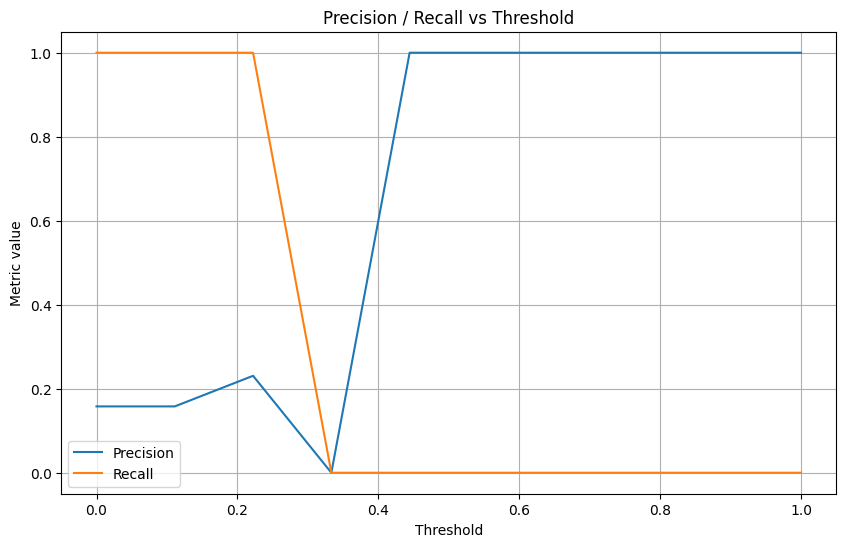

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")

plt.xlabel("Threshold")
plt.ylabel("Metric value")
plt.title("Precision / Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


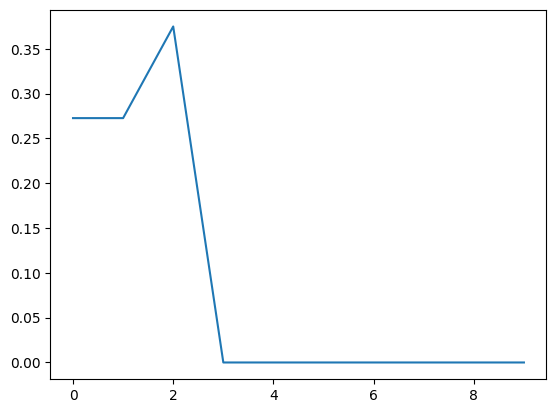

In [43]:
plt.plot(f1_scores)

## 4. Оценка качества
Для каждой построенной модели, по отложенной тестовой выборке оцените качество моделей:
* accuracy
* precision
* recall
* roc-auc
* постройте матрицу ошибок
  


=== Trivial Classifier ===
Accuracy : 0.842
Precision: 0.000
Recall   : 0.000
ROC-AUC  : N/A


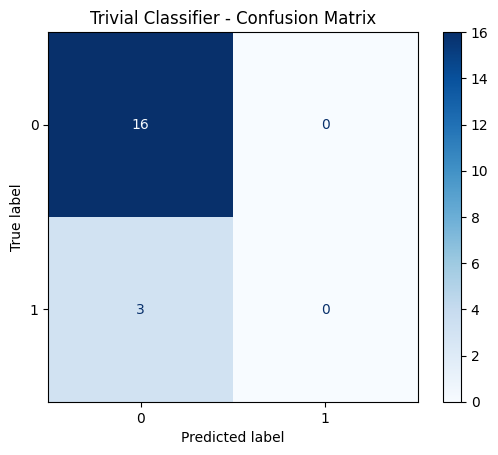


=== Logistic Regression ===
Accuracy : 0.842
Precision: 0.000
Recall   : 0.000
ROC-AUC  : 0.14583333333333331


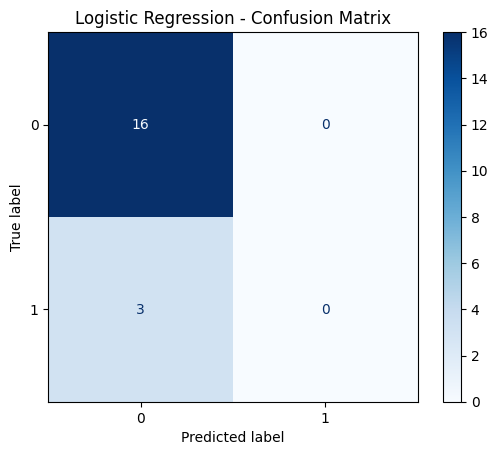


=== Naive Bayes ===
Accuracy : 0.737
Precision: 0.000
Recall   : 0.000
ROC-AUC  : N/A


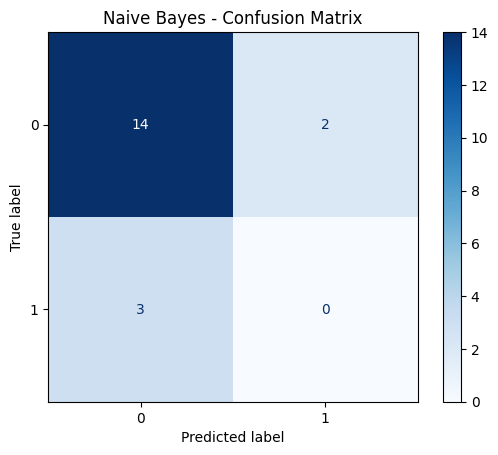


=== k-NN ===
Accuracy : 0.789
Precision: 0.000
Recall   : 0.000
ROC-AUC  : N/A


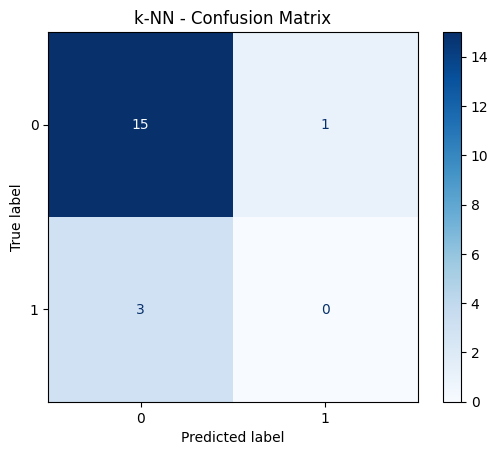

In [44]:
models = {
    "Trivial Classifier": TrivialClassifier(),
    "Logistic Regression": LogisticRegression(threshold=0),  
    "Naive Bayes": NaiveBayesClassifier(),        
    "k-NN": KNNClassifier(k=3)                
}

for name, model in models.items():
    print(f"\n=== {name} ===")

    model.fit(X_val, y_val)

    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test).flatten()
        y_pred = (y_probs >= 0.5).astype(int)
    else:  
        y_pred = model.predict(X_test)
        y_probs = None 
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    
    if y_probs is not None:
        roc_auc = roc_auc_score(y_test, y_probs)
    else:
        roc_auc = "N/A"
    
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"ROC-AUC  : {roc_auc}")
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()
